# Vehicle detection

In [20]:
# data processing
# import importlib
# importlib.reload(helper)
import helper

# manipulate directories and files
import os
import glob

# plotting
import matplotlib.pyplot as plt

# loading image
import matplotlib.image as mpimg

# math
import numpy as np

# hog features
from skimage.feature import hog

# OpenCV
import cv2

In [11]:
output_images_dir = 'output_images/'

## Data exploration


In order to train a classifier, we will use a dataset comprised of images taken from the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train the classifier.

In [12]:
dataset_dir = "dataset"

helper.download_extract('vehicle', dataset_dir)
helper.download_extract('non-vehicle', dataset_dir)

Found vehicle Data
Found non-vehicle Data


In [16]:
# cars_path = os.path.join(dataset_dir, 'vehicles/**/*.png')

car_path = dataset_dir + "/vehicles/**/*.png"
# car_path = "examples/*.png"
cars_images = glob.glob(car_path, recursive=True)
cars = []

# print(len(cars_images))
# print(cars_images)
for image in cars_images:
    cars.append(image)

# notcars_path = os.path.join(dataset_dir, 'non-vehicles/**/*.png')
notcars_path = dataset_dir + "/non-vehicles/**/*.png"
# print(notcars_path)
notcars_images = glob.glob(notcars_path, recursive=True)
notcars = []

for image in notcars_images:
    notcars.append(image)
# print(len(notcars))

In [17]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

The dataset contains 8792 cars and 8968 non-cars
of size:  (64, 64, 3)  and data type: float32


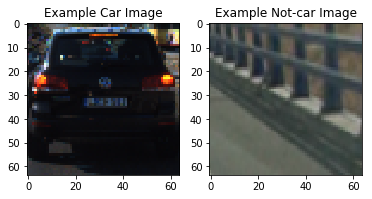

In [18]:
data_info = data_look(cars, notcars)

print('The dataset contains', 
      data_info["n_cars"], 'cars and', 
      data_info["n_notcars"], 'non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images# READ IN CAR / NOT-CAR IMAGES


car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
filename = output_images_dir + "car_notcar_example.png"
plt.savefig(filename)
plt.show()


## Features extraction

In [75]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
image = mpimg.imread(cars[ind])

### Histograms of colors

In [76]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1]) / 2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features

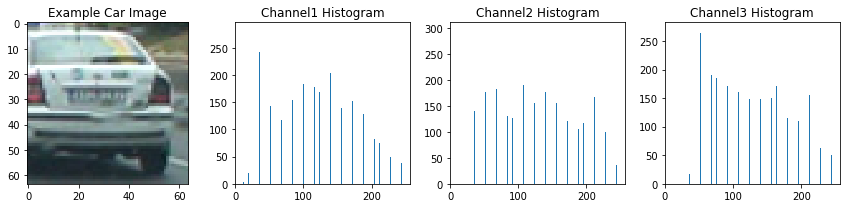

In [83]:
# rescale the image values from 0-1 to 0-255
img_scale = np.uint8(image * 255)
ch1h, ch2h, ch3h, bincen, feature_vec = color_hist(img_scale, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if ch1h is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(image)
    plt.title('Example Car Image')
    plt.subplot(142)
    plt.bar(bincen, ch1h[0])
    plt.xlim(0, 256)
    plt.title('Channel1 Histogram')
    plt.subplot(143)
    plt.bar(bincen, ch2h[0])
    plt.xlim(0, 256)
    plt.title('Channel2 Histogram')
    plt.subplot(144)
    plt.bar(bincen, ch3h[0])
    plt.xlim(0, 256)
    plt.title('Channel3 Histogram')
    fig.tight_layout()
    plt.show()
else:
    print('Your function is returning None for at least one variable...')

### HOG features

In [64]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    Extract HOG features and ability to vizualiza the result
    """
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                 visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                 visualise=vis, feature_vector=feature_vec)
        return features

/Users/virt/anaconda3/envs/autonomous-car/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


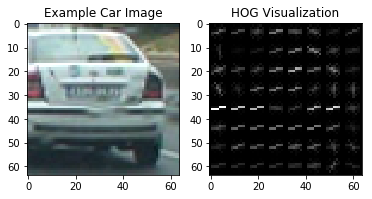

In [78]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
filename = output_images_dir + "hog_visualization.png"
plt.savefig(filename)
plt.show()

Extract features from a list of images

In [ ]:
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    
    

## Finding cars

In [ ]:
def find_cars()